In [11]:
# This IPython notebook is a supplement to Hines & Hetland, "Rapid and
# simultaneous estimation of fault slip and heterogeneous lithospheric
# viscosity from postseismic deformation", submitted to Geophysical
# Journal International in 2015
#
# The json file for this IPython notebook can be found at
# github.com/treverhines or by contacting the authors

from sympy import init_session
init_session(quiet=True)
from __future__ import division
import numpy as np
import sympy as sp

IPython console for SymPy 0.7.6 (Python 2.7.10-64-bit) (ground types: gmpy)


#Inverse Laplace transform function
The functions defined here are used to symbolically evaluate the
inverse Laplace transform with the method described in Appendix A of
the main text.

In [12]:
def ivt(uhat,s,n):
  '''
  Extension of the initial value theorem which computes the n'th
  derivative of u(t) evaluated at t=0 from the Laplace transform of
  u(t), uhat(s).

  This is eq. (A.5) in Appendix A

  PARAMETERS
  ----------
    uhat: Laplace transform of u. This is a symbolic expression
      containing s
    s: Laplace domain variable
    n: the derivative order

  RETURNS
  -------
    u_n: symbolic expression for the nth derivative of u evaluated at
      t=0
  '''
  if n == 0:
    expr = s*uhat
    u_0 = expr.limit(s,np.inf)
    return u_0

  elif n > 0:
    expr = s**(n+1)*uhat - sum(s**m*ivt(uhat,s,n-m) for m in range(1,n+1))
    u_n = expr.limit(s,np.inf)
    return u_n

def ilt(uhat,s,t,N):
  '''
  Evaluates the inverse Laplace transform of uhat(s) through a Taylor
  series expansion

  This is a combination of eqs. (A.7) and (A.5) in Appendix A

  PARAMETERS
  ----------
    uhat: Laplace transform of u. This is a symbolic expression
      containing s
    s: Laplace domain variable
    t: time domain variable
    N: order of the Taylor series expansion

  RETURNS
  -------
    series: symbolic expression for the series expansion of the u(x)
     about x=0
  '''
  series = sum((ivt(uhat,s,n)*t**n)/sp.factorial(n) for n in range(N+1))
  return series

#Two-dimensional, two layered earthquake model
We consider a two-dimensional, two layered earthquake model.  We
demonstrate here that the initial rate of surface deformation
resulting from viscoelastic relaxation is linear with respect to the
fluidities of the two layers, regardless of whether the the shear
moduli are equal.  We follow the same proceduce as in Section 2.1.1
in the main text but we do not assume that $\mu_1=\mu_2$ We start with
the elastic solution from Rybicki (1971).

##Variables used
* x: distance from fault
* t: time
* D: locking depth of the fault
* H: thickness of the top layer
* mu1,mu2: shear modulus of the top layer and lower substrate
* phi1,phi2: fluidity (1/viscosity) of the top layer and lower substrate


In [14]:
# define shear moduli parameters

mu1,mu2 = sp.symbols('mu1,mu2')

# define viscosity parameters

eta1,eta2 = sp.symbols('eta1,eta2')

# define fluidity parameters

phi1,phi2 = sp.symbols('phi1,phi2')
etainv1,etainv2,etainv3 = sp.symbols('eta1^-1,eta2^-1,eta3^-1')

# time, dummy variable for time integration, and Laplace domain parameter

t,theta,s = sp.symbols('t,theta,s')

# slip function.  This needs to be explicitly defined and I define it
# here as one unit of slip throughout the postseismic period

b = 1

# dummy summation variable

n = sp.symbols('n')

# distance from the fault

x = sp.symbols('x')

# locking depth and upper layer thickness

D,H = sp.symbols('D H')

# number of terms to approximate the infinite series

nmax = 3

# W is eq. (3) in the main text and it is defined here as a function
# rather than an explicit expression for the sake of cleaner output

W = sp.Function('W')(n)

# eq. (4) in the main text

gamma = (mu1-mu2)/(mu1+mu2)

# eq. (2) in the main text. This describes the elastic surface
# displacements

u_e2 = b*(sp.Rational(1,2)*W.subs(n,0) + sp.summation(gamma**n*W,(n,1,nmax)))

# eq. (5) in the main text. The Laplace transform of equation 2

uhat_e2 = sp.laplace_transform(u_e2,t,s)[0]

# eq. (8) in the main text. These are the shear modulii in the Laplace
# domain for a Maxwell viscoelastic material. Note I am using fluidity
# instead of viscosity here

mu1hat = s/((s/mu1) + phi1)
mu2hat = s/((s/mu2) + phi2)

# eq. (6) in the main text. This is the Laplace transform of the
# viscoelastic surface displacements

uhat_v2 = uhat_e2.subs(((mu1,mu1hat),(mu2,mu2hat)))

# The following is the initial rate of surface deformation, which is 
# resulting from viscoelastic relaxation. The solution is long and we
# substitute the terms with coefficients phi1 and phi2 with F1 and 
# F2, respectively, making it apparent that the initial rate of 
# deformation is indeed linear with respect to the fluidities

# Print u_v2 after this line to see the solution without 
# substitutions 
u_v2_init_vel = ivt(uhat_v2,s,1)
u_v2_init_vel = u_v2_init_vel.expand().collect((phi1,phi2))
F1,F2 = sp.symbols('F1,F2')
u_v2_init_vel = u_v2_init_vel.subs(u_v2_init_vel.coeff(phi1),F1)
u_v2_init_vel = u_v2_init_vel.subs(u_v2_init_vel.coeff(phi2),F2)
u_v2_init_vel

In [15]:
# If we assuming that the shear moduli are equal and take the 
# inverse Laplace transform then we recover eq. (10) in the text,
# with the exception that b(t) is explicitly defined here

u_v2 = ilt(uhat_v2.subs(mu2,mu1),s,t,2)
u_v2

#Two-dimensional, three layered earthquake model
We consider a three layered, two-dimensional viscoelastic earthquake
model.  We demonstrate the derivation of eq. (14) in the main text. We
use the solution for the three layered elastic solution from Chinnery
and Jovanovich (1972).

##variables used:
* x: distance from fault
* t: time
* mu1,mu2,mu3: shear modulus for the top, middle, and bottom layer
* phi1,phi2,phi3: fluidity (1/viscosity) for the top, middle, and
  bottom layer
* h3,h2: thichness of the top and middle layer
* p: depth to the bottom of the fault. (down is positive)


In [16]:
# define shear moduli parameters

mu3,mu2,mu1 = sp.symbols('mu3,mu2,mu1')

# define fluidity parameters

phi1,phi2,phi3 = sp.symbols('phi1,phi2,phi3')

# time, dummy variable for time integration, and Laplace domain
# parameter

t,theta,s = sp.symbols('t,theta,s')

# slip function.  This needs to be explicitly defined and I define it
# here as one unit of slip throughout the postseismic period

b = 1

# dummy summation variable

M,N = sp.symbols('M,N')

# distance from the fault

x = sp.symbols('x')

# locking depth

p = sp.symbols('p')

# eq. (13) in main text which is only expressed as a function for
# cleaner output

W = sp.Function('W')(M,N)

# eq. iii from Chinnery and Jovanovich (1972)

l_max = 2
m_max = 2
n_max = 2

a1    = (mu2 - mu3) / (mu2 + mu3)
a2    = (mu1 - mu2) / (mu1 + mu2)
a3    = -1
b1    = 2*mu3 / (mu3 + mu2)
b2    = 2*mu2 / (mu2 + mu1)
b3    = 2
d1    = 2*mu2 / (mu3 + mu2)
d2    = 2*mu1 / (mu2 + mu1)


def P(l,m,n):
  N = sp.factorial(n+1) * sp.factorial(l+m-1)
  D = sp.factorial(l) * sp.factorial(n) * sp.factorial(l-1) * sp.factorial(m)
  return N / D

def Q(l,m,n):
  N = sp.factorial(n+l) * sp.factorial(l+m)
  D = sp.factorial(l) * sp.factorial(n) * sp.factorial(l) * sp.factorial(m)
  return N / D

u = -b3*sp.Rational(-1,2)*W.subs(((N,0),(M,0)))
for n in range(n_max):
  coeff = a2*b3*(-a2*a3)**n
  u += coeff*W.subs(((M,0),(N,n+1)))

for l in range(1,l_max):
  for m in range(m_max):
    for n in range(n_max):
      coeff = a2*b3*(-a1*a2)**m*(-a2*a3)**n*(-a2*a3*d2*b2)**l*P(l,m,n)
      u += coeff*W.subs(((M,l+m),(N,l+n+1)))

for l in range(l_max):
  for m in range(m_max):
    for n in range(n_max):
      coeff = a1*d2*b2*b3*(-a1*a3)**m*(-a2*a3)**n*(-a1*a3*d2*b2)**l*Q(l,m,n)
      u += coeff*W.subs(((M,l+m+1),(N,l+n+1)))
     
u_e3 = sp.Rational(1,2)*b*u

In [17]:
# This is the Laplace transform of the elastic displacements

uhat_e3 = sp.laplace_transform(u_e3,t,s)[0]

# define the equivalent shear modulii for a Maxwell viscoelastic body

mu1hat = s/((s/mu1) + (phi1))
mu2hat = s/((s/mu1) + (phi2))
mu3hat = s/((s/mu1) + (phi3))

# substitute the equivalent shear moduli into the Laplace transform of
# the elastic displacements to get the Laplace transform of the
# viscoelatic displacements

uhat_v3 = uhat_e3.subs(((mu1,mu1hat),(mu2,mu2hat),(mu3,mu3hat)))

# take the inverse Laplace transform to find the viscoelastic
# displacements in the time domain. I am only expanding to the first
# two terms.  We recover eq. (14) in the main text if you note that
# slip is explicitly defined, and the numbering of the layers is
# reversed here.

u_v3 = ilt(uhat_v3,s,t,1)
u_v3

#Two-dimensional, two layered model with Burgers rheology
We consider a two-dimensional, two layered earthquake model which has
a Burgers rheology.  Specifically we demonstrate that
an approximation for early displacements will have the same form as
eq. (11) in the main text.  If we assume that the Maxwell shear
modulus in the Burgers model is equal to the shear modulus in eq. (11)
then the difference between the two approximations is that the
fluidities ($1/\eta_i$) in eq. (11) are replaced with the sum of the
fluidities for the Maxwell and Kelvin element ($1/\eta_i^k +
1/\eta_i^m$).  We extrapolate from this simple two layered example
that the initial rate of deformation in a Burgers earthquake model
with an arbitrarily discretized geometry is linear with respect to
($1/\eta_i^k + 1/\eta_i^m$).

We once again start with the elastic solution from Rybicki (1971) and
use the Correspondence Principle of Viscoelasticity to find the
viscoelastic solution for a Burgers rheology.

##Variables used
* x: distance from fault
* t: time
* D: locking depth of the fault
* H: thickness of the top layer
* mu1,mu2: shear modulus of the top layer and lower substrate in the
  elastic model
* muk1,muk2: Kelvin shear modulus for the top layer and lower
  substrate in the Burgers model
* mum1,mum2: Maxwell shear modulus for the top layer and lower
  substrate in the Burgers model
* etam1,etam2: Maxwell viscosity for the top layer and lower substrate
  in the Burgers model
* etak1,etak2: Kelvin viscosity for the top layer and lower substrate
  in the Burgers model


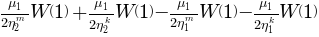

In [20]:
# define shear moduli for the elastic model

mu1,mu2 = sp.symbols('mu1,mu2')

# define kelvin shear moduli parameters

muk1,muk2 = sp.symbols('mu_1^k,mu_2^k')

# define maxwell shear moduli parameters

mum1,mum2 = sp.symbols('mu_1^m,mu_2^m')

# define kelvin viscosity parameters

etak1,etak2 = sp.symbols('eta_1^k,eta_2^k')

# define maxwell viscosity parameters

etam1,etam2 = sp.symbols('eta_1^m,eta_2^m')

# time, dummy variable for time integration, and Laplace domain
# parameter

t,theta,s = sp.symbols('t,theta,s')

# slip function.  This needs to be explicitly defined and I define it
# here as one unit of slip throughout the postseismic period

b = 1

# dummy summation variable

n = sp.symbols('n')

# distance from the fault

x = sp.symbols('x')

# locking depth and upper layer thickness

D,H = sp.symbols('D H')

# number of terms to approximate the infinite series

nmax = 3

# W is eq. (3) in the main text and it is defined here as a function
# rather than an explicit expression for the sake of cleaner output

W = sp.Function('W')(n)

# eq. (4) in the main text

gamma = (mu1-mu2)/(mu1+mu2)

# eq. (2) in the main text. This describes the elastic surface
# displacements

u_e2 = b*(sp.Rational(1,2)*W.subs(n,0) + sp.summation(gamma**n*W,(n,1,nmax)))

# eq. (5) in the main text.  The Laplace transform of equation 2

uhat_e2 = sp.laplace_transform(u_e2,t,s)[0]

# These are the shear moduli in the Laplace domain for a Burgers
# viscoelastic material taken from Hetland and Hager 2005.

phi0 = 1
psi0 = 0
phi1 = etam1/mum1 + etam1/muk1 + etak1/muk1
psi1 = etam1
phi2 = (etam1*etak1)/(mum1*muk1)
psi2 = (etam1*etak1)/muk1
mu1hat = (psi0 + psi1*s + psi2*s**2)/(phi0 + phi1*s + phi2*s**2)

phi0 = 1
psi0 = 0
phi1 = etam2/mum2 + etam2/muk2 + etak2/muk2
psi1 = etam2
phi2 = (etam2*etak2)/(mum1*muk1)
psi2 = (etam2*etak2)/muk2
mu2hat = (psi0 + psi1*s + psi2*s**2)/(phi0 + phi1*s + phi2*s**2)

# We replace the shear moduli in the two layer elastic solution with
# the above shear moduli

uhat_v2_burgers = uhat_e2.subs(mu1,mu1hat)
uhat_v2_burgers = uhat_v2_burgers.subs(mu2,mu2hat)

# For the sake of simplicity we will assume that mu_m1=mu_m2=mu1 and
# mu_k1=mu_k2=mu2 (i.e. the Maxwell and Kelvin shear moduli are 
# homogenous)

uhat_v2_burgers = uhat_v2_burgers.subs(mum1,mu1)
uhat_v2_burgers = uhat_v2_burgers.subs(mum2,mu1)
uhat_v2_burgers = uhat_v2_burgers.subs(muk1,mu2)
uhat_v2_burgers = uhat_v2_burgers.subs(muk2,mu2)

# compute the initial rate of displacement
u_v2_burgers = ivt(uhat_v2_burgers,s,1)

# It is evident from the the second term in the Taylor series of
# displacement that the initial velocities have the same form as the
# initial velocities when we assume a Maxwell rheology.  The
# difference is that (1/eta_i) is replaced with (1/eta_ki + 1/eta_mi).

u_v2_burgers.expand()

#References

Chinnery, M.A. & Jovanovich, D.B, 1972. Effect of earth layering on
  earthquake displacement fields, Bull. Seismol. Soc. Am. 62,
  1629-1639.

Rybicki, K., 1971. The elastic residual field of a very long
  strike-slip fault in the presence of a discontinuity,
  Bull. Seismol. Soc. Am., 61, 79-92.

Hetland, E. & Hager, B., 2005. Postseismic and interseismic
  displacement near a strike-slip fault: a two-dimensional theory for
  general linear viscoelastic rheologies. J. Gephys. Res.: Solid
  Earth, 110, 1-21
